# About this Colab

This is a Notebook made to experiment with LLM, RAG and Vector Databases. This notebook uses the [AI library from DNALinux](https://github.com/DNALinux/ai).

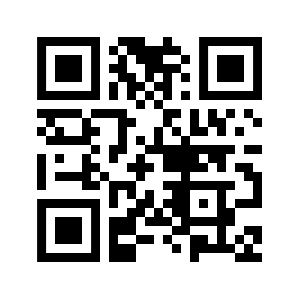

## What is RAG

Retrieval-Augmented Generation (RAG) is a technique used in natural language processing (NLP) that enhances the capabilities of large language models (LLMs) by incorporating external knowledge sources. Instead of solely relying on the information stored in the LLMs, you can use RAG to retrieve relevant information from external databases or documents to generate more comprehensive and accurate responses. This approach enables LLMs to access and process real-time information, domain-specific knowledge, and factual data that may not be present in their training data, thereby improving their overall performance and accuracy.

## What is a Vector Database

Vector Databases are specialized databases designed to efficiently store and retrieve high-dimensional vectors, often used as representations of data like text, images, or audio. These databases utilize similarity search algorithms to quickly identify vectors that are most similar to a given query vector. In the context of RAG, vector databases are used to store and retrieve the embeddings of external knowledge sources, allowing LLMs to quickly locate relevant information based on the semantic similarity of their queries.

## How they are related

Relationship between RAG and Vector Databases: In RAG, vector databases serve as the knowledge source, storing information in the form of embeddings. When an LLM receives a query, it generates an embedding for the query and uses it to search the vector database for similar embeddings representing relevant information. The retrieved information is then used by the LLM to augment its response, making it more comprehensive and accurate.

 **Note**: If you are seeing this notebook in GitHub or in a non-colab server, press the following button to run it in Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DNALinux/ai/blob/main/notebooks/DNALinux_RAG.ipynb)

# Preparation work (install dependencies)

In [1]:
!apt install pciutils lshw
!curl -fsSL https://ollama.com/install.sh | sh
!git clone https://github.com/DNALinux/ai.git
!cd ai && uv venv && uv pip install -r requirements.txt --python /content/ai/.venv/bin/python
!mkdir -p /content/testdata1/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids usb.ids
The following NEW packages will be installed:
  libpci3 lshw pci.ids pciutils usb.ids
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 883 kB of archives.
After this operation, 3,256 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 pci.ids all 0.0~2022.01.22-1ubuntu0.1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 lshw amd64 02.19.git.2021.06.19.996aaad9c7-2build1 [321 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/main amd64 usb.ids all 2022.04.02-1 [219 kB]
Fetched 883 kB in 2s (431 kB/s)
Selecting previously unselected package pc

# Start the LLM server (Ollama)

In [2]:
import os
import threading
import subprocess
import requests
import json

def ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])


ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()

# Download Embedded and LLM model

There are 2 types of models needed for RAG: An **embedding model** and an **LLM**. The embedding model converts external data like PDF files into vectors and populates the vector database. A user’s query is vectorized and matched to relevant data in the database via similarity search. The LLM receives the query and retrieved context, producing a response that combines its internal knowledge with the new information.

We recommend one of these two embedded models: *nomic-embed-text* or *mxbai-embed-large*. Both models perform well, and we recommend testing them with your dataset to determine which delivers better results. Note that once you select an embedded model, you must use the same model for both indexing (storing data) and querying (retrieving data). There are more embedded models available but they are not recommended since they take more resources.

Your choice of LLM model depends on your GPU's capabilities and your tolerance for wait times.

## Key Considerations

Speed vs. Quality: Larger models deliver higher-quality outputs but respond slower. Smaller models are faster but produce less accurate results.

Balance: For a middle ground between speed, resource usage, and output quality, consider **Gemma:12B** or **Llama3.1:8B**.

T4 Compatibility: **Phi4** offers strong performance and, despite its size, is compatible with T4 GPUs.

Larger models (e.g., **Llama4** or **Llama3.3:70B**) require significant GPU RAM (over 50 GB). On platforms like Google Colab, this is only feasible with an A100 GPU. Don't use T4 GPUs for these models, as they are incompatible.

In [3]:
# @title Select models to download
import subprocess
# @markdown ---
# @markdown Select an embedding model:

embedding_model = "mxbai-embed-large" # @param ["nomic-embed-text", "mxbai-embed-large", "bge-m3"]
!ollama pull {embedding_model}

# @markdown Select a LLM model:

LLM_model = "gemma3:4b" # @param ["phi4", "deepseek-r1:7b", "gemma3:4b", "gemma3:12b", "llama4", "llama3.3:70b", "llama3.2:3b", "llama3.1:8b"]
!ollama pull {LLM_model}
# @markdown ---
# @markdown ### For more information on available models, check [Ollama](https://ollama.com/search)

!ollama list



NAME                        ID              SIZE      MODIFIED               
gemma3:4b                   a2af6cc3eb7f    3.3 GB    Less than a second ago    
mxbai-embed-large:latest    468836162de7    669 MB    43 seconds ago            


# Data ingestion

This is done only once to create the vector database out of you data, a directory with PDF files. Next cell reads all the PDF files in the **data_dir** directory, and it is processed into a Vector database named **db_name** and located at **db_dir**

In [4]:
# @title Convert your data and load the vector DB
# @markdown Select the data source (*data_dir*) and the destination of the vector database (*db_name* and *db_dir*).

# @markdown ---
# @markdown ### Directory with source data (PDFs):
data_dir = "/content/ai/data/blastpdfs/" # @param {type:"string"}
# @markdown ### Vector database name and path:
db_name = "blastDB" # @param {type:"string"}
db_dir = "/content/testdata1/" # @param {type:"string"}
# @markdown ---
!/content/ai/.venv/bin/python ai/scripts/createDBColab.py --db_dir {db_dir} --db_name {db_name} --v_llm {embedding_model} --input_dir {data_dir}


Vector model: mxbai-embed-large
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Current documents: 
0
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given
Current documents: 
556
**


# Sample text from a journal

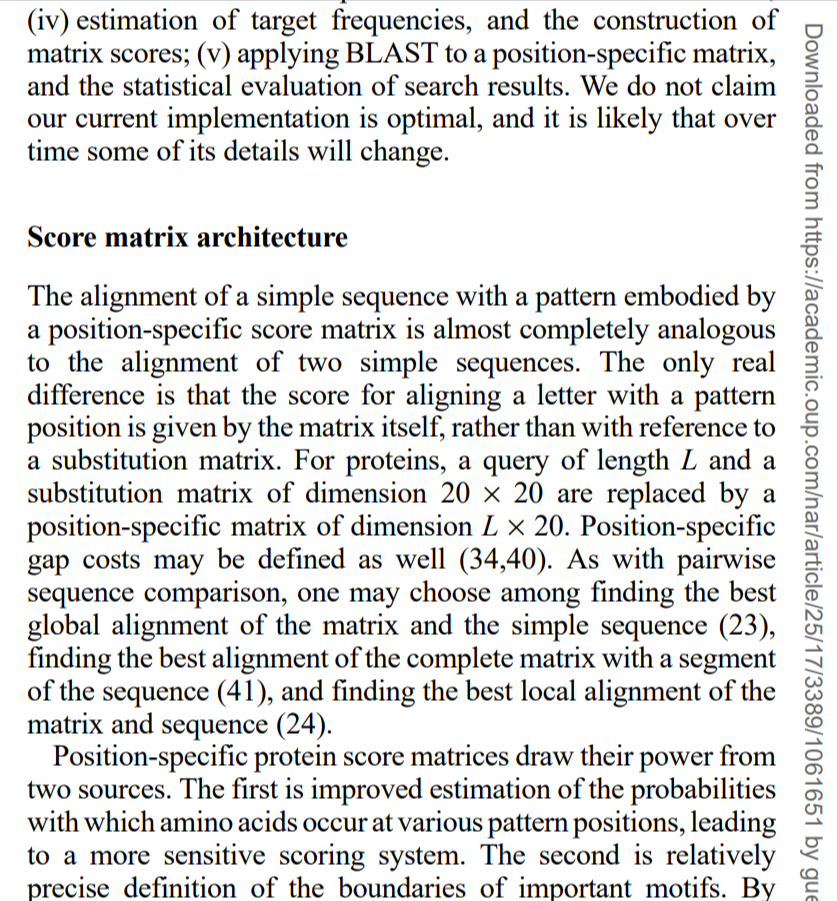

In [5]:
from google.colab import widgets


# @title Compare RAG query vs LLM query

# @markdown ---
# @markdown Select the embedded model:
embedded_model = "mxbai-embed-large" # @param ["nomic-embed-text", "mxbai-embed-large"]
# @markdown Select the LLM model:
LLM_model = "gemma3:4b" # @param ["phi4", "deepseek-r1:7b", "gemma3:4b", "gemma3:12b", "llama4", "llama3.3:70b", "llama3.2:3b", "llama3.1:8b"]
# @markdown Enter vector database directory and name:
db_dir = "/content/testdata1/" # @param {type:"string"}
db_name = "blastDB" # @param {type:"string"}
# @markdown Enter a prompt:
query = "What is the difference between the alignment of a simple sequence with a pattern embodied by a position-specific score matrix to the alignment of two simple sequences?" # @param {type:"string"}
# @markdown ---

pypath = "/content/ai/.venv/bin/python"
grid = widgets.Grid(1, 2, header_row=True, header_column=True)


with grid.output_to(0, 0):
    print(f"Query against the LLM ({LLM_model})")
    !ollama run {LLM_model} {query}
with grid.output_to(0, 1):
    print(f"Query against the RAG ({LLM_model} and {db_name} vector database)")
    !{pypath} ai/scripts/RAG_query.py --e_model {embedded_model} --LLM_model {LLM_model} --db_dir {db_dir} --db_name {db_name} --query "{query}"


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Query against the LLM (gemma3:4b)
Okay, let's break down the differences between aligning a sequence with a position-specific scoring matrix (PSSM) and aligning two simple sequences. These are fundamental concepts in bioinformatics, particularly in sequence alignment algorithms like Smith-Waterman.

**1. Alignment with a PSSM (Single Sequence Alignment)**

* **What it is:**  When you align a single sequence (let's call it 'query') with a PSSM, you're essentially asking the question: "Where is this query sequence *most likely* to be found within a larger database of sequences?"

* **How it works:**
    * **PSSM:** A PSSM is a matrix where each row represents a specific amino acid position in the expected alignment. Each column in the matrix contains a score indicating how likely that amino acid is to be found at that position.  High scores indicate a strong preference for that amino acid at that position.
    * **Scanning:** The algorithm *scans* the PSSM across the query sequence.  At 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Query against the RAG (gemma3:4b and blastDB vector database)
Embedding model: mxbai-embed-large
LLM: gemma3:4b
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given
Q: What is the difference between the alignment of a simple sequence with a pattern embodied by a position-specific score matrix to the alignment of two simple sequences?

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
The alignment of a simple sequence with a pattern embodied by a position-specific score matrix is almost completely ana

<IPython.core.display.Javascript object>

In [ ]:
# @title Run a query against the LLM
# @markdown This query will be done without using RAG

# @markdown ---
# @markdown ### Select a model:
LLM_model = "gemma3:4b" # @param ["phi4", "gemma3:4b", "gemma3:12b", "llama4", "llama3.3:70b", "llama3.2:3b", "llama3.1:8b"]
# @markdown ### Enter a prompt:
query = "What is the MedGen data model? Provide a list of data elements aggregated in MedGen" # @param {type:"string"}
# @markdown ---

!ollama run {LLM_model} {query}


Okay, let's break down the MedGen data model and the data elements it aggregates. MedGen is a unique, highly detailed, and complex database of biomedical literature. It’s not just a collection of abstracts; it's a meticulously constructed knowledge base designed to support drug discovery and biomedical research.

**What is the MedGen Data Model?**

The MedGen data model is built around a highly structured, relational database. It's designed to capture and link information from a vast number of sources—primarily scientific articles, patents, and conference proceedings—to create a network of interconnected biomedical knowledge. Here’s a breakdown of the key aspects:

* **Core Concepts:** The model revolves around concepts like:
    * **Genes:** Individual genes and their variants.
    * **Proteins:**  Detailed information about proteins, including their sequences, structures, and functions.
    * **Chemicals:**  Pharmaceutical compounds, metabolites, and other chemicals.
    * **Diseases

In [ ]:
# @title Run a RAG query
# @markdown This is a RAG query (based in your data)

# @markdown ---
# @markdown ### Select the embedded model:
embedded_model = "mxbai-embed-large" # @param ["nomic-embed-text", "mxbai-embed-large"]
# @markdown ### Select the LLM model:
LLM_model = "phi4" # @param ["phi4", "gemma3:4b", "gemma3:12b", "llama4", "llama3.3:70b", "llama3.2:3b", "llama3.1:8b"]
# @markdown ### Enter vector database directory and name:
db_dir = "/content/testdata2/" # @param {type:"string"}
db_name = "blastdb" # @param {type:"string"}
# @markdown ### Enter a prompt:
query = "What is the MedGen data model? Provide a list of data elements aggregated in MedGen" # @param {type:"string"}
# @markdown ---

pypath = "/content/miniforge3/envs/ml/bin/python"
!{pypath} ai/scripts/RAG_query.py --e_model {embedded_model} --LLM_model {LLM_model} --db_dir {db_dir} --db_name {db_name} --query "{query}"





Embedding model: mxbai-embed-large
LLM: phi4
Q: What is the MedGen data model? Provide a list of data elements aggregated in MedGen

I don't know the answer because there is no context provided regarding the MedGen data model or its data elements.
***********



In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:4b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:4b
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are:

1.  **Task:** Changing the default values of command-line arguments, including nucleotide match and mismatch values, to optimize the search for different scenarios. Specifically, for the MEGABLAST task, the nucleotide match and mismatch values are 1 and -2, corresponding to 95% identity matches, while for BLASTN and DISCONTIGUOUS MEGABLAST, the values are 2 and -3, corresponding to 85% identity.
2.  **Integration with WindowMasker:** Utilizing the windowmasker files via the -window_masker_taxid and WINDOW_MASKER_PATH configuration parameter or via the -window_masker_db command line option.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
Here’s a breakdown of the MedGen data model and the components of a MedGen record, based on the provided text:

**MedGen Data

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:4b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:4b
Q: Regarding Blast+, which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are:

1.  **Reward megablast integer 1**
2.  **Penalty megablast integer -2**
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
Here’s a breakdown of the MedGen data model and the components of a MedGen record, based on the provided text:

**MedGen Data Model:**

The MedGen data model is designed to be simple. It centers around identifying a concept (a disorder or phenotype) and then gathering and reporting information related to that concept. This information is categorized as:

*   **Descriptors:** General descriptions of the concept.
*   **Links to other databases:** Connections to resources like NCBI databases, OMIM®, and ClinVar.
*   **Concept-Concept Relationships:** Links between related disorders, features, or other concepts.

**Components of

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model llama3.1:8b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: llama3.1:8b
Q: Regarding Blast+, which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are:

1. **Scoring parameters**: The scoring parameters for insertions, deletions, and mismatches need to be defined, which include:
	* Reward (or match score) for a nucleotide match
	* Penalty for a nucleotide mismatch
2. **Gap penalty strategy**: The gap penalty strategy needs to be defined, which can be either a linear gap penalty or an affine gapping strategy.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is a simple data model that once a concept is identified, categories of information related to that concept are identified and reported.

A MedGen record has several important components including:

* Author Affiliation
* Concept ID (a stable unique identifier)
* Definition or description
* Clinical findings
* Causati

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:12b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:12b
Q: Regarding Blast+, which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are near gap penalty and affine gapping.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple: once a concept is identified, categories of information related to that concept are identified and reported.

A MedGen record has several important components including:
*   Author Affiliation
*   Definition or description
*   Clinical findings
*   Causative genetic variants and genes
*   Clinical and research tests
*   Molecular resources
*   Professional guidelines
*   Literature
*   Consumer resources
*   Clinical trials
*   Web links
***********

Q: Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment
The context d

In [ ]:
!ollama run llama3.2:3b "Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment"

⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠇ ⠇ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠙ ⠹ ⠼ ⠴ ⠴ ⠦ In the standard dynamic programming (DP) algorithms for pairwise sequence alignment, such as Needleman-Wunsch or Smith-Waterman, each cell in the scoring matrix represents a certain amount of computation.

The dimensions of this fixed amount of computation per cell are:

* **Rows**: The number of rows corresponds to the length of one of the sequences being aligned. Specifically, it's the length of the sequence with more positions, or 0 if both sequences have the same length.
* **Columns**: The number of columns also corresponds to the length of the other sequence being aligned.

In other words, each cell in the scoring matrix represents a trade-off between:

1. Matching a character at position i in one sequence and its corresponding character at position j in the other sequence (scored as +1).
2. Not matching these characters (scored as -1 for penalties, if present).

For example, if we have t

In [ ]:
!ollama run llama4 "Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment"

⠙ ⠹ ⠸ ⠼ ⠴ Error: model requires more system memory (56.0 GiB) than is available (11.4 GiB)


In [ ]:
!ollama run gemma3:12b "Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment"

⠋ ⠹ ⠸ ⠼ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠹ ⠼ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠦ ⠧ ⠇ ⠇ ⠏ ⠋ ⠹ ⠹ ⠼ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠧ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠴ ⠧ ⠇ ⠇ ⠏ ⠋ ⠙ ⠸ ⠸ ⠴ ⠴ ⠦ ⠧ ⠏ ⠋ ⠙ ⠙ ⠸ ⠸ ⠼ ⠦ ⠧ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠸ ⠼ ⠴ ⠴ ⠧ ⠇ ⠇ ⠋ ⠙ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠇ ⠏ ⠏ ⠙ ⠙ ⠸ ⠸ ⠴ ⠴ ⠧ ⠧ ⠏ ⠋ ⠙ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠏ ⠙ ⠹ ⠸ ⠸ ⠼ ⠴ ⠧ ⠧ ⠏ ⠏ ⠙ ⠹ ⠹ ⠸ ⠼ ⠦ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠸ ⠸ ⠼ ⠦ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠼ ⠼ ⠦ ⠧ ⠧ ⠇ ⠏ ⠙ ⠙ ⠹ ⠼ ⠴ ⠴ ⠧ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠋ ⠋ ⠙ ⠸ ⠼ ⠴ ⠦ ⠦ ⠧ ⠇ ⠋ ⠙ ⠹ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠙ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠋ ⠙ ⠙ ⠹ ⠸ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠸ ⠼ ⠴ ⠴ ⠧ ⠇ ⠇ ⠏ Okay, let's break down the dimensions of the fixed computation per cell in dynamic programming algorithms for pairwise sequence alignment (specifically, focusing on standard approaches like Needleman-Wunsch and Smith-Waterman).

**Understanding the Context: Dynamic Programming for Sequence Alignment**

Dynamic programming (DP) for sequence alignment construc

In [ ]:
!ollama run gemma3:12b "What is the difference between the alignment of a simple sequence with a pattern embodied by a position-specific score matrix to the alignment of two simple sequences"

⠙ ⠹ Okay, let's break down the difference between aligning a sequence to a Position-Specific Scoring Matrix (PSSM) versus aligning two simple sequences.  The core concept is that PSSMs offer a more nuanced and sophisticated way of capturing the "pattern" you're trying to find compared to a direct sequence-to-sequence comparison.

**1. Aligning Two Simple Sequences (Traditional Sequence Alignment)**

* **What it is:** This is the classic sequence alignment you probably learned about first.  It involves comparing two DNA, RNA, or protein sequences and finding the best possible arrangement (introducing gaps if necessary) to maximize the similarity between them.
* **Scoring:**  It uses a simple scoring system.  Generally:
    * **Match:** Positive score (e.g., +1, +2) - When the characters at aligned positions are the same.
    * **Mismatch:** Negative score (e.g., -1, -2) - When the characters are different.
    * **Gap Penalty:** Negative score (either gap open penalty for introducing a 

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:12b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:12b
Q: Which are the 2 most important criteria to design the new BLAST code?
Reward for a nucleotide match and penalty for a nucleotide mismatch.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
A MedGen record has components including a definition or description, clinical findings, causative genetic variants, available clinical and research tests, molecular resources, professional guidelines, literature, consumer resources, clinical trials, and Web links.
***********

Q: Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment
I do not have the answer.
***********

Q: What is the difference between the alignment of a simple sequence with a pattern embodied by a position-specific score matrix to the alignment of two simple sequences
The alignment of a sequence with a pattern embodied by a positio

In [ ]:
# changed rag context question
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:12b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:12b
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are: nucleotide match reward (1 or 2) and nucleotide mismatch penalty (-2 or -3).
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple: once a concept is identified, categories of information related to that concept are identified and reported.

A MedGen record has several important components including:
*   Author Affiliation
*   Links to other databases
*   Concept-concept relationships
***********

Q: Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment
The text does not specify the exact dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence 

In [ ]:
# changed rag context question
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:12b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:12b
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are the reward for a nucleotide match and the penalty for a nucleotide mismatch.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple: once a concept is identified, categories of information related to that concept are identified and reported.

A MedGen record has several important components including:
*   Author Affiliation
*   Clinical findings
*   Causative genetic variants and the genes in which they occur
*   Available clinical and research tests
*   Molecular resources
*   Professional guidelines
*   Original and review literature
*   Consumer resources
*   Clinical trials
*   Web links
***********

Q: Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model phi4 --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: phi4
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria for designing the new BLAST code are:

1. **Reward and Penalty Values**: These determine how nucleotide matches and mismatches affect scoring during searches. For example, different tasks such as "megablast," "blastn," and "dc-megablast" have specific reward and penalty values assigned to optimize search performance for particular scenarios.

2. **Gap Parameters and Sequence Filtering**: This includes parameters like `dustmasker`, `windowmasker`, and the `best-hit` filtering algorithm, which help in identifying low-complexity regions or overly represented sequences that may not be of interest. These filters ensure efficient searching by managing sequence complexity and relevance.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is designed to organize information related to huma

In [ ]:
# changed rag context question
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model gemma3:12b --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: gemma3:12b
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are a nucleotide match reward and a nucleotide mismatch penalty. The values depend on the task. For example, for the MEGABLAST task, the reward is 1 and the penalty is -2. For BLASTN and DISCONTIGUOUS MEGABLAST, the reward is 2 and the penalty is -3.
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple: once a concept is identified, categories of information related to that concept are identified and reported.

A MedGen record has several components including:

*   Author Affiliation
*   Definition or description
*   Clinical findings
*   Causative genetic variants and genes
*   Clinical and research tests
*   Molecular resources
*   Professional guidelines
*   Literature
*   Consumer resources
*   Clinical trials
*   Web links
**********

In [ ]:
!ollama run llama3.3:70b "Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment"

⠋ ⠹ ⠸ ⠸ ⠼ ⠴ ⠦ ⠇ ⠇ ⠋ ⠋ ⠙ ⠸ ⠼ ⠴ ⠦ ⠧ ⠧ ⠇ ⠏ ⠋ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠙ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠦ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠹ ⠸ ⠼ ⠴ ⠧ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠹ ⠼ ⠼ ⠴ ⠧ ⠧ ⠇ ⠏ ⠙ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠹ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠙ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠋ ⠋ ⠹ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠋ ⠋ ⠹ ⠹ ⠸ ⠴ ⠴ ⠦ ⠇ ⠏ ⠏ ⠋ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠧ ⠏ ⠏ ⠋ ⠙ ⠸ ⠼ ⠴ ⠴ ⠧ ⠧ ⠇ ⠋ ⠙ ⠙ ⠹ ⠼ ⠼ ⠴ ⠦ ⠇ ⠇ ⠋ ⠋ ⠙ ⠸ ⠸ ⠼ ⠴ ⠧ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠹ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠦ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ ⠴ ⠦ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠼ ⠴ ⠦ ⠧ ⠧ ⠇ ⠏ ⠋ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠧ ⠇ ⠋ ⠋ ⠹ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠹ ⠼ ⠴ ⠴ ⠦ ⠧ ⠇ ⠏ ⠙ ⠹ ⠸ ⠼ ⠼ ⠦ ⠧ ⠧ ⠏ ⠏ ⠙ ⠹ ⠸ ⠸ ⠼ ⠦ ⠧ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠼ ⠦ ⠦ ⠇ ⠏ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠹ ⠸ ⠼ ⠴ ⠦ ⠦ ⠧ ⠇ ⠋ ⠋ ⠙ ⠸ ⠸ ⠼ ⠦ ⠦ ⠧ ⠏ ⠋ ⠙ ⠙ ⠸ ⠸ ⠴ ⠦ ⠦ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠼ ⠦ ⠧ ⠇ ⠇ ⠏ ⠋ ⠙ ⠹ ⠼ ⠼ ⠦ ⠦ ⠇ ⠏ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠧ ⠧ ⠇ ⠏ ⠋ ⠹ ⠹ ⠼ ⠼ ⠴ ⠧ ⠇ ⠏ ⠋ ⠋ ⠙ ⠸ ⠼ ⠼ ⠴ ⠦ ⠇ ⠏ ⠏ ⠋ ⠹ ⠸ ⠼ ⠼ ⠦ ⠦ ⠇ ⠇ ⠋ ⠋ ⠹ ⠹ ⠼ ⠴ ⠴ ⠧ ⠇ ⠇ ⠋ ⠋ ⠙ ⠹ ⠸ ⠼ ⠦ ⠦ ⠇ ⠏ ⠋ ⠙ ⠹ ⠹ ⠸ ⠼ ⠴ ⠧ ⠧ ⠇ ⠏ 

In [ ]:
!ollama run llama3.2:3b "Which are the 2 most important criteria to design the new BLAST code?"

^C


In [ ]:
!ollama run llama3.2:3b "What is the difference between the alignment of a simple sequence with a pattern embodied by a position-specific score matrix to the alignment of two simple sequences"

When aligning a simple sequence (a short DNA or protein sequence) with a pattern embodied by a position-specific score matrix, also known as local alignment, the goal is to find the best match between the two sequences. This type of alignment is typically performed using algorithms such as Smith-Waterman or Needleman-Wunsch.

In contrast, when aligning two simple sequences together (i.e., comparing two sequences against each other), this is known as a global alignment problem. The main difference between these two types of alignments is the way they approach finding the best match.

Here are some key differences:

**Local Alignment:**

* Focuses on finding a local match between the sequence and the pattern, rather than an overall similarity.
* Typically used for identifying short motifs or patterns within a longer sequence.
* The alignment is usually scored based on a score matrix that reflects the likelihood of each residue being part of the pattern (e.g., a matrix with high scores fo

In [ ]:
!ollama run llama3.2:3b "What is the MedGen data model? What are the components of a MedGen record?"

⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠋ ⠙ ⠙ ⠹ ⠸ ⠴ ⠴ ⠧ ⠇ ⠇ ⠏ ⠙ ⠙ ⠹ ⠼ ⠼ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠧ ⠏ ⠋ ⠋ ⠙ ⠸ ⠼ ⠼ ⠴ ⠧ ⠧ ⠏ ⠏ ⠋ ⠙ ⠹ ⠸ ⠴ The MedGen (Medical Genetic) database is a comprehensive online repository of human genes and their relationships to diseases, disorders, traits, and other conditions. The MedGen data model is a standardized way of representing gene-related information in a structured format.

A MedGen record consists of several key components:

1. **Gene**:
	* Gene symbol (e.g., BRCA1)
	* Gene name
	* Organism (human, mouse, rat, etc.)
2. **Inheritance Pattern**:
	* Inherited pattern (autosomal dominant, autosomal recessive, X-linked dominant, etc.)
	* Probability of inheritance
3. **Disease/Disorder Relationship**:
	* Disease or disorder name
	* Relationship type (e.g., causative, associative, diagnostic)
4. **Trait**:
	* Trait description (e.g., height, eye color)
5. **Genotype**:
	* Allele information (e.g., variant names, frequencies)
6. **Phenotype**:
	* Phenotype desc

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/testRAG.py --v_model mxbai-embed-large --LLM_model phi4 --db_dir /content/testdata1/ --db_name blastdb

Vector model: mxbai-embed-large
LLM: phi4
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria for designing the new BLAST code are:

1. **Scoring Parameters**: This includes defining reward and penalty values for nucleotide matches and mismatches. Different tasks (e.g., MEGABLAST vs. BLASTN) have different scoring parameters optimized for specific scenarios.

2. **Task Optimization**: The concept of a "task" allows the software to optimize searches by adjusting command-line arguments, such as word size and default scoring parameters, according to the task's requirements (e.g., high sensitivity vs. speed).
***********

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple, focusing on identifying a concept related to human disorders or phenotypes and categorizing associated information into descriptors, links to other databases, and concept-concept relationships.

Components of a

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/demo_colab_2.py

Vector model: nomic-embed-text
Q: Which are the 2 most important criteria to design the new BLAST code?
Two important criteria for designing a new BLAST code are:

1. Speed: The new design should aim to improve the speed of the search while maintaining or improving its sensitivity.
2. Sensitivity: The new design should also consider increasing the sensitivity of the search to weak similarities, which can be challenging due to the tradeoff with speed.
Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model has a simple structure, where categories of information related to a concept are identified and reported. A MedGen record has several important components:

1. Author Affiliation
2. Definition (with attribution and link to source)
3. Identifiers from source databases
4. Gene-phenotype relationships
5. Cytogenetic locations
6. Inter-concept relationships
7. Published literature
8. Dataflow (includes aggregation, curation, and querying)
Q: Whi

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/demo_colab_2.py

Vector model: mxbai-embed-large
Q: Which are the 2 most important criteria to design the new BLAST code?
The two most important criteria to design the new BLAST code are: 
1. Reward for a nucleotide match
2. Penalty for a nucleotide mismatch.

Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple, categorizing information related to a concept into descriptors, links to other databases, or concept-concept relationships. A MedGen record has several components including definition, clinical findings, causative genetic variants, genes, available tests, molecular resources, professional guidelines, literature, and Web links to other NCBI and non-NCBI resources.

Q: Which are the dimensions of the fixed amount of computation per cell of a path graph in the standard dynamic programming algorithms for pairwise sequence alignment
The dimensions are not explicitly stated in the provided context.

Q: What is the difference between the alignm

In [ ]:
  !/content/miniforge3/envs/ml/bin/python ai/scripts/demo_colab_2.py

Vector model: nomic-embed-text
Q: What is the MedGen data model? What are the components of a MedGen record?
ERROR:root:Error querying the vector database: [Errno 111] Connection refused
ERROR:root:Error generating answer: [Errno 111] Connection refused
Error generating answer.


In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/demo_colab_2.py

Vector model: mxbai-embed-large
Q: Which are the 2 most important criteria to design the new BLAST code?
Based on general knowledge of software design principles and user experience, two important criteria for designing the new BLAST code are:

1. **User Interface**: A user-friendly interface that allows users to easily input parameters, select options, and view results without requiring extensive technical expertise.
2. **Flexibility and Customization**: The ability to allow users to save and reuse custom command-line options, strategy files, or other configurations to accommodate their specific research needs and workflows.
Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model is simple, with a record consisting of several components:

1. Author Affiliation
2. Definition or description
3. Clinical findings
4. Causative genetic variants and genes
5. Available clinical and research tests
6. Molecular resources
7. Professional guidelines
8. 

In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/scripts/demo_colab.py

Vector model: nomic-embed-text
Q: What is the MedGen data model? What are the components of a MedGen record?
The MedGen data model consists of categories of information that relate to a specific concept, including:

1. Author Affiliation
2. Identifiers from source databases
3. Gene-phenotype relationships
4. Cytogenetic locations
5. Inter-concept relationships
6. Published literature
Traceback (most recent call last):
  File "/content/ai/scripts/demo_colab.py", line 40, in <module>
    xxxxxxxxxx
NameError: name 'xxxxxxxxxx' is not defined


In [ ]:
# see data sources


In [ ]:
# load from URLs



In [ ]:
# check how many documents there are in the DB



In [ ]:
!ollama list

NAME                       ID              SIZE      MODIFIED       
llama3.2:3b                a80c4f17acd5    2.0 GB    10 seconds ago    
nomic-embed-text:latest    0a109f422b47    274 MB    3 hours ago       


In [ ]:
!/content/miniforge3/envs/ml/bin/python ai/queryDBColab.py

Vector model: nomic-embed-text
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_embeddings', '_load_or_create_vector_db', '_process_and_add', 'chroma_db_dir', 'clear_database', 'collection_name', 'count_docs', 'delete_source', 'load_data', 'load_html', 'load_pdf', 'load_url', 'model', 'peek', 'query', 'query_sources', 'show_sources', 'vector_db']
NewDB
{'ids': [], 'embeddings': [], 'metadatas': [], 'documents': [], 'uris': None, 'data': None, 'included': ['embeddings', 'metadatas', 'documents']}
**


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_embeddings', '_load_or_create_vector_db', '_process_and_add', 'chroma_db_dir', 'clear_database', 'collection_name', 'count_docs', 'delete_source', 'load_data', 'load_html', 'load_pdf', 'load_url', 'model', 'peek', 'query', 'query_sources', 'show_sources', 'vector_db']


# Advanced options

In [ ]:
import tempfile


# @title Adjust model parameters
# @markdown To adjust model parameter in Ollama, you need to create a derived model. This cell will generate a derived model.

# @markdown **Warning**: Not all model support all parameter. Using wrong parameters may generate a degraded model.

# @markdown ---
# @markdown Select a model to change (input model):
LLM_model = "gemma3:4b" # @param ["phi4", "gemma3:4b", "gemma3:12b", "llama4", "llama3.3:70b", "llama3.2:3b", "llama3.1:8b"]
# @markdown Enter new model name:
new_model = "genma3T07" # @param {type:"string"}
# @markdown Enter new template file name (if blank will use a random name):
tpl_fn = "" # @param {type:"string","placeholder":"Modelfile"}

if tpl_fn == "":
    # make a random filename
    tpl_fn = tempfile.mktemp(suffix='.txt')

# @markdown Temperature:  Increasing the temperature will make the model answer more creatively.
temp = 0.7 # @param {"type":"slider","min":0,"max":1,"step":0.05}
# @markdown num_ctx: Sets the size of the context window used to generate the next token
num_ctx = 4018 # @param {"type":"slider","min":1024,"max":18000,"step":1}
# @markdown seed: Sets the size of the context window used to generate the next token
seed = 4482 # @param {"type":"slider","min":0,"max":10000,"step":1}
# @markdown Maximum number of tokens to predict when generating text. (Default: -1, infinite generation)
num_predict = 4790 # @param {"type":"slider","min":-1,"max":10000,"step":1}
# @markdown Top K: Reduces the probability of generating nonsense. A higher value will give more diverse answers, while a lower value will be more conservative.
top_k = 20 # @param {"type":"slider","min":1,"max":100,"step":1}
# @markdown Top P: Works together with top-k. A higher value will lead to more diverse text, while a lower value will generate more focused and conservative text.
top_p = 0.47 # @param {"type":"slider","min":0,"max":1,"step":0.01}
# @markdown Min P: Alternative to the top_p, and aims to ensure a balance of quality and variety. The parameter p represents the minimum probability for a token to be considered, relative to the probability of the most likely token. For example, with p=0.05 and the most likely token having a probability of 0.9, logits with a value less than 0.045 are filtered out.
min_p = 0 # @param {"type":"slider","min":0,"max":1,"step":0.01}


# @markdown ---

# @markdown [More about model parameters](https://github.com/ollama/ollama/blob/main/docs/modelfile.md#valid-parameters-and-values)

# @markdown ---
model_file = f"""FROM {LLM_model}
PARAMETER temperature {temp}
PARAMETER num_ctx {num_ctx}
PARAMETER seed {seed}
PARAMETER num_predict {num_predict}
PARAMETER top_k {top_k}
PARAMETER top_p {top_p}
PARAMETER min_p {min_p}
"""

#mdir = "/content/miniforge3/envs/ml/lib/python3.10/site-packages/ollama/models/"

with open(f"{tpl_fn}", "w") as f:
    f.write(model_file)


!ollama create {new_model} -f {tpl_fn}



gathering model components 
using existing layer sha256:aeda25e63ebd698fab8638ffb778e68bed908b960d39d0becc650fa981609d25 
using existing layer sha256:e0a42594d802e5d31cdc786deb4823edb8adff66094d49de8fffe976d753e348 
using existing layer sha256:dd084c7d92a3c1c14cc09ae77153b903fd2024b64a100a0cc8ec9316063d2dbc 
creating new layer sha256:5c713b945982e66464f922de12120c66e8453df5ea5bfa57c16b629e7c6d7cd6 
writing manifest 
success 


In [ ]:
# @title Run a query against the LLM
# @markdown This query will be done without using RAG

# @markdown ---
# @markdown ### Enter a prompt:
query = "What is the MedGen data model? Provide a list of data elements aggregated in MedGen" # @param {type:"string"}
# @markdown ---

!ollama run {new_model} {query}


Okay, let's break down the MedGen data model and the data elements it aggregates. MedGen is a unique and powerful research database developed by the U.S. Department of Veterans Affairs (VA) to support clinical research. It's not a standard database, and its data model is quite complex, reflecting the VA's extensive clinical data collection practices.

**Core Principles of the MedGen Data Model**

The MedGen data model is built around the concept of **Clinical Research Data Objects (CRDOs)**.  Instead of a traditional relational database, MedGen organizes data around these CRDOs, which represent specific pieces of clinical information that researchers are interested in.  Here's a breakdown of the key aspects:

* **CRDOs (Clinical Research Data Objects):** These are the fundamental building blocks. They represent a specific clinical event or measurement. Examples include:
    * **Medication Events:**  Specific instances of medication administration.
    * **Laboratory Measurements:**  Re

In [ ]:
# @title Run a query against the LLM
# @markdown This query will be done without using RAG

# @markdown ---
# @markdown ### Enter a prompt:
query = "What is the MedGen data model? Provide a list of data elements aggregated in MedGen" # @param {type:"string"}
# @markdown ---
print(f"Model name: {new_model}")
!ollama run {new_model} {query}


Model name: genma3T0
⠙ Okay, let's break down the MedGen data model and the data elements it aggregates. MedGen is a unique and powerful resource, and its data model is a key part of its value.

**What is the MedGen Data Model?**

MedGen is a comprehensive, curated database of biomedical literature, primarily focused on the areas of:

*   **Neuroscience:**  This is its core strength, encompassing neurology, psychiatry, neurobiology, and related fields.
*   **Pharmacology & Toxicology:**  A significant portion of the data relates to drug effects, mechanisms of action, and adverse reactions.
*   **Genetics & Genomics:**  Data on gene function, mutations, and genetic disorders.

The data model isn't a traditional relational database in the sense of tables with strict foreign keys. Instead, it’s a **graph-based knowledge representation**. This means information is linked together based on semantic relationships, rather than just stored in separate tables. This allows for incredibly complex

In [ ]:
# @title Run a query against the LLM
# @markdown This query will be done without using RAG

# @markdown ---
# @markdown ### Enter a prompt:
query = "What is the MedGen data model? Provide a list of data elements aggregated in MedGen" # @param {type:"string"}
# @markdown ---
print(f"Model name: {new_model}")
!ollama run {new_model} {query}

Model name: genma3T0
⠙ Okay, let's break down the MedGen data model and the data elements it aggregates. MedGen is a unique and powerful resource, and its data model is a key part of its value.

**What is the MedGen Data Model?**

MedGen is a comprehensive, curated database of biomedical literature, primarily focused on the areas of:

*   **Neuroscience:**  This is its core strength, encompassing neurology, psychiatry, neurobiology, and related fields.
*   **Pharmacology & Toxicology:**  A significant portion of the data relates to drug effects, mechanisms of action, and adverse reactions.
*   **Genetics & Genomics:**  Data on gene function, mutations, and genetic disorders.

The data model isn't a traditional relational database in the sense of tables with strict foreign keys. Instead, it’s a **graph-based knowledge representation**. This means information is linked together based on semantic relationships, rather than just stored in separate tables. This allows for incredibly complex

In [ ]:
# @title (OPTIONAL) Convert your data from URLs and load the vector DB

url_file = "/content/ai/data/raw/urls/index.urls" # @param {type:"string"}
db_dir = "/content/testdata1/" # @param {type:"string"}
db_name = "blastdb" # @param {type:"string"}

pypath = "/content/miniforge3/envs/ml/bin/python"

cmd = f"{pypath} ai/scripts/addurlstodbcolab.py --db_dir {db_dir} --db_name {db_name} --v_llm {vmodel} --url_input_file {url_file}"
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    print("Command output:\n", result.stdout)
else:
    print("Error:", result.stderr)


Command output:
 Vector model: nomic-embed-text
Current documents: 
476
Current documents: 
3334
**




```
e83f45542ae3: mxbai-embed-large gemma3:4b 140s
9ca86cca4e06: mxbai-embed-large gemma3:12b 280s
5a24890401d6: mxbai-embed-large phi4 465s
fcf1ec5d3f5a: nomic-embed-text gemma3:4b 135s
5a372a7f6b5f: nomic-embed-text gemma3:12b 274s
3473c7041527: nomic-embed-text phi4 491s
```

